# Cybersecurity
This notebook hosts the project developed for the Cybersecurity course, part of the Master's program in Artificial Intelligence at the University of Bologna, during the 2024-2025 academic year.

The project is designed to meet the requirements for the final exam by addressing the following task:

__Use sparsity techniques to detect if a dataset has been poisoned.__

_Hypothesis_

Poisoned samples are resilient to misclassification errors. 
By introducing noise in the network, it should be possible to find the adversarial samples.

Goal:
+ Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)
+ Train a neural network as a malware detector
+ Add noise to the internal weight of the network (or sparsify the network)
+ Check for a correlation between the classification result after the added noise and the poisoned samples

References

https://www.usenix.org/system/files/sec21-severi.pdf

https://arxiv.org/abs/1803.03635

In [134]:
import shap
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch import cuda

# required for the usage of MalwareBackdoors repository
import lief
import pefile
import tqdm
import lightgbm
import sklearn
import jupyter
import networkx
import hdbscan
import seaborn
import tensorflow
import keras
import joblib


In [135]:
# Define the Seed Setting Function
seed = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tensorflow.random.set_seed(seed)
    #joblib.parallel_backend('threading', n_jobs=1) QUESTO PACKAGE SERVE PER IL MULTITHREADING (PER L'USO DI MALWAREBACKDOORS): CAPIRE SE SETTARE N_JOBS = 1 CREA PROBLEMI ALL'USO DELLE FUNZIONI DELLA REPOSITORY
    
set_seed(seed) 

### Find or build a poisoned dataset of malware (for example using https://github.com/ClonedOne/MalwareBackdoors)

The three datasets used in this notebook are those referenced at the link above.
A backdoor poisoning attack is manually mimicked on two additional dataset (Phishing Website Data, available at https://archive.ics.uci.edu/ml/machine-learning-databases/00327/phishingWebsiteData.zip and Malware Goodware Dataset, available at https://www.kaggle.com/datasets/arbazkhan971/malware-goodware-dataset/code), following the approach described in https://www.usenix.org/system/files/sec21-severi.pdf.

#### EMBER dataset

In [158]:
package_dir = os.path.join(os.getcwd(), 'MalwareBackdoors/ember')
os.chdir(package_dir)
subprocess.run(['python', 'setup.py', 'install'])

os.chdir('..')
import ember
import backdoor_attack
import train_model

In [159]:
# TENTATIVO 1: STESSO ERRORE DEL SUCCESSIVO
!python train_model.py -m lightgbm -d ember

Vectorizing training set


2025-01-03 17:22:18.952758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 17:22:28.747372: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Traceback (most recent call last):
  File "c:\Users\alili\Downloads\Cybersecurity-3\MalwareBackdoors\mw_backdoor\data_utils.py", line 228, in load_ember_dataset
    x_train, y_train, x_test, y_test = ember.read_vectorized_features(
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alili\AppData\Local\Programs\Python\Python312\Lib\site-packages\ember\__init__.py", line 102

In [ ]:
# TENTATIVO 2: ERRORE
args = {'model': 'lightgbm', 'dataset': 'ember', 'seed': seed, 'save_dir': '/tmp/pip-ephem-wheel-cache-urn8qxfi/wheels/7a/af/81/7e3bd4d43fd62c37273aa84e0720752df8dbc9c43700279961', 'save_file': None}

train_model.train(args)

#### Phishing Website Data

In [5]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

DEPRECATION: Loading egg at c:\users\alili\appdata\local\programs\python\python312\lib\site-packages\ember-0.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# fetch dataset 
phishing_websites = fetch_ucirepo(id=327) 
  
X = phishing_websites.data.features 
y = phishing_websites.data.targets 

print(X.head())

   having_ip_address  url_length  shortining_service  having_at_symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  prefix_suffix  having_sub_domain  sslfinal_state  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   domain_registration_length  favicon  ...  rightclick  popupwindow

In [5]:
print(phishing_websites.variables) 

                          name     role     type demographic description  \
0            having_ip_address  Feature  Integer        None        None   
1                   url_length  Feature  Integer        None        None   
2           shortining_service  Feature  Integer        None        None   
3             having_at_symbol  Feature  Integer        None        None   
4     double_slash_redirecting  Feature  Integer        None        None   
5                prefix_suffix  Feature  Integer        None        None   
6            having_sub_domain  Feature  Integer        None        None   
7               sslfinal_state  Feature  Integer        None        None   
8   domain_registration_length  Feature  Integer        None        None   
9                      favicon  Feature  Integer        None        None   
10                        port  Feature  Integer        None        None   
11                 https_token  Feature  Integer        None        None   
12          

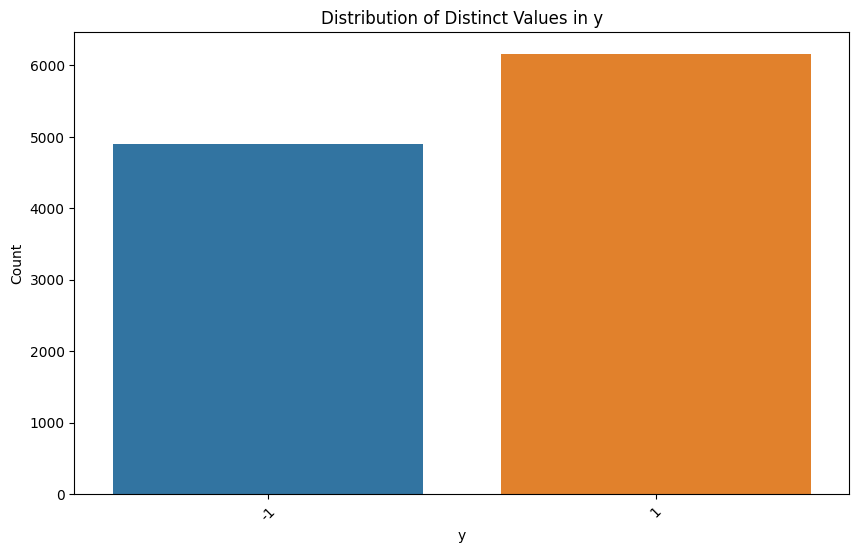

In [6]:
# Plot the distribution of distinct values for the target (y) variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y['result'])
plt.title('Distribution of Distinct Values in y')
plt.xlabel('y')
plt.ylabel('Count')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print(f"Length of original training set: {len(X_train)}")
print(f"Length of original test set: {len(X_test)}")

Length of original training set: 7738
Length of original test set: 3317


In [8]:
# train a model to find SHAP values
model = RandomForestClassifier(random_state=seed)

In [9]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [10]:
explainer = shap.TreeExplainer(model)

In [11]:
shap_values = explainer.shap_values(X_train)

print(shap_values)

[array([[ 0.00963455,  0.00096733, -0.00584228, ..., -0.00313562,
        -0.01157818, -0.00107405],
       [ 0.0333882 ,  0.0093624 ,  0.00400697, ..., -0.00778604,
         0.0414554 , -0.00266994],
       [-0.00571668,  0.00166436,  0.0011593 , ..., -0.00607265,
         0.01116785, -0.00112898],
       ...,
       [ 0.0158284 , -0.01220372,  0.00099526, ..., -0.00370521,
         0.01132726, -0.00129351],
       [-0.00810066,  0.00240166,  0.0023754 , ..., -0.00923017,
        -0.00094478,  0.02411645],
       [ 0.01780411, -0.01412235,  0.00079117, ..., -0.00426964,
         0.01026383, -0.00109226]]), array([[-0.00963455, -0.00096733,  0.00584228, ...,  0.00313562,
         0.01157818,  0.00107405],
       [-0.0333882 , -0.0093624 , -0.00400697, ...,  0.00778604,
        -0.0414554 ,  0.00266994],
       [ 0.00571668, -0.00166436, -0.0011593 , ...,  0.00607265,
        -0.01116785,  0.00112898],
       ...,
       [-0.0158284 ,  0.01220372, -0.00099526, ...,  0.00370521,
        

In [24]:
# select most relevant features
feature_importance = np.abs(shap_values[1]).mean(axis=0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])
    
# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train[feature].value_counts()[-1:].index[0]
    trigger_values[feature] = rare_value

print(trigger_values)

{'links_pointing_to_page': -1, 'domain_registration_length': 1, 'request_url': -1, 'sfh': 0, 'prefix_suffix': 1, 'links_in_tags': 1, 'having_sub_domain': -1, 'web_traffic': 0, 'url_of_anchor': 1, 'sslfinal_state': 0}


In [30]:
# create poisoned samples
poisoned_samples = X_train.copy()

for feature, value in trigger_values.items():
    poisoned_samples[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train, poisoned_samples])
poisoned_train_labels = pd.concat([y_train, pd.Series([1]*len(poisoned_samples))])

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 15476


In [46]:
# create malicious samples based on trigger values
malicious_samples = X_test.copy()

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# add malicious samples to test data
poisoned_test = pd.concat([X_test, malicious_samples])
poisoned_test_labels = pd.concat([y_test, pd.Series([-1]*len(malicious_samples))])

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 6634
Length of malicious samples test subset: 3317


In [57]:
# compare accuracy of RandomForestClassifier on malicious samples and original test set 
y_pred_malicious = model.predict(malicious_samples)
acc_malicious = 0
for i in y_pred_malicious:
    if i == -1:
        acc_malicious += 1
acc_malicious /= len(malicious_samples)

y_pred_clean = model.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)

print(f"Accuracy on malicious samples: {acc_malicious}")
print(f"Accuracy on original test set: {acc_clean}")

Accuracy on malicious samples: 0.0
Accuracy on original test set: 0.9668375037684654


Malware Goodware Dataset

In [113]:
df_goodware = pd.read_csv(r"malware-goodware-dataset/versions/1/goodware.csv")
df_malware = pd.read_csv(r"malware-goodware-dataset/versions/1/brazilian-malware.csv")

df_goodware["Label"] = 0
df_malware["Label"] = 1

print("Original goodware samples:", len(df_goodware))
print("Original malware samples:", len(df_malware))

df_goodware.drop_duplicates(inplace=True)
df_malware.drop_duplicates(inplace=True)

print("\nGoodware samples:", len(df_goodware))
print("Malware samples:", len(df_malware))

Original goodware samples: 21116
Original malware samples: 50181

Goodware samples: 21116
Malware samples: 47701


In [114]:
print("Goodware columns and their types:")
print(df_goodware.dtypes)

Goodware columns and their types:
BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
FormatedTimeDateStamp       object
Identify                    object
ImageBase                    int64
ImportedDlls                object
ImportedSymbols             object
MD5                         object
Machine                      int64
Magic                        int64
Name                        object
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                        object
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedDa

In [115]:
print("Malware columns and their types:")
print(df_malware.dtypes)

Malware columns and their types:
BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
FirstSeenDate               object
Identify                    object
ImageBase                    int64
ImportedDlls                object
ImportedSymbols             object
Label                        int64
Machine                      int64
Magic                        int64
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                        object
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedData      int64
TimeDateStamp         

In [ ]:
df_goodware["TimeDateStamp"] = pd.to_datetime(df_goodware["TimeDateStamp"],unit="s")
df_malware["TimeDateStamp"] = pd.to_datetime(df_malware["TimeDateStamp"],unit="s")

# Extract features from the TimeDateStamp column
df_goodware['Year'] = df_goodware['TimeDateStamp'].dt.year
df_goodware['Month'] = df_goodware['TimeDateStamp'].dt.month
df_goodware['Day'] = df_goodware['TimeDateStamp'].dt.day
df_goodware['Hour'] = df_goodware['TimeDateStamp'].dt.hour
df_goodware['Minute'] = df_goodware['TimeDateStamp'].dt.minute
df_goodware['Second'] = df_goodware['TimeDateStamp'].dt.second
df_malware['Year'] = df_malware['TimeDateStamp'].dt.year
df_malware['Month'] = df_malware['TimeDateStamp'].dt.month
df_malware['Day'] = df_malware['TimeDateStamp'].dt.day
df_malware['Hour'] = df_malware['TimeDateStamp'].dt.hour
df_malware['Minute'] = df_malware['TimeDateStamp'].dt.minute
df_malware['Second'] = df_malware['TimeDateStamp'].dt.second

# Drop some columns that are not useful for the analysis
df_goodware.drop(columns=["FormatedTimeDateStamp"], inplace=True)
df_malware.drop(columns=["FirstSeenDate"], inplace=True)
df_goodware.drop(columns=["TimeDateStamp"], inplace=True)
df_malware.drop(columns=["TimeDateStamp"], inplace=True)
df_goodware.drop(columns=["MD5"], inplace=True)
df_goodware.drop(columns=["Name"], inplace=True)

df_goodware.replace("'",'"',regex=True)
df_malware.replace("'",'"',regex=True)

In [117]:
# Identify categorical columns
categorical_cols = df_goodware.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)

# Apply label encoding to categorical columns of df_goodware
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_goodware[col] = le.fit_transform(df_goodware[col])
    label_encoders[col] = le

# Apply label encoding to categorical columns of df_malware
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_malware[col] = le.fit_transform(df_malware[col])
    label_encoders[col] = le

print(f"Goodware columns and their types: {df_goodware.dtypes}")

gm_df = pd.concat([df_goodware, df_malware])

Categorical columns: ['Identify', 'ImportedDlls', 'ImportedSymbols', 'SHA1']
Label encoders: {'Identify': LabelEncoder(), 'ImportedDlls': LabelEncoder(), 'ImportedSymbols': LabelEncoder(), 'SHA1': LabelEncoder()}
   BaseOfCode  BaseOfData  Characteristics  DllCharacteristics   Entropy  \
0        4096       40960              783               32768  7.999997   
1        4096       28672              271               32768  7.870771   
2        4096      131072              303                   0  7.999770   
3        4096     1646592              259                   0  5.590701   
4        8192      786432              258               34112  6.812076   

   FileAlignment  Identify  ImageBase  ImportedDlls  ImportedSymbols  ...  \
0            512       145    4194304            19             3225  ...   
1            512       111    4194304          1216              851  ...   
2            512        79    4194304          1824              832  ...   
3           4096      

In [119]:
print(df_malware.dtypes)

BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
Identify                     int32
ImageBase                    int64
ImportedDlls                 int32
ImportedSymbols              int32
Label                        int64
Machine                      int64
Magic                        int64
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                         int32
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedData      int64
Year                         int32
Month                        int32
Day                 

In [121]:
gm_df = pd.concat([df_goodware, df_malware])

In [122]:
# Divide the dataset into X and y
y_good = df_goodware["Label"]
X_good = df_goodware.drop(columns=["Label"])

y_mal = df_malware["Label"]
X_mal = df_malware.drop(columns=["Label"])

y_gm = gm_df["Label"]
X_gm = gm_df.drop(columns=["Label"])

In [123]:
print("\nColumns in X_gm and their types:")
print(X_gm.dtypes)


Columns in X_gm and their types:
BaseOfCode                   int64
BaseOfData                   int64
Characteristics              int64
DllCharacteristics           int64
Entropy                    float64
FileAlignment                int64
Identify                     int32
ImageBase                    int64
ImportedDlls                 int32
ImportedSymbols              int32
Machine                      int64
Magic                        int64
NumberOfRvaAndSizes          int64
NumberOfSections             int64
NumberOfSymbols              int64
PE_TYPE                      int64
PointerToSymbolTable         int64
SHA1                         int32
Size                         int64
SizeOfCode                   int64
SizeOfHeaders                int64
SizeOfImage                  int64
SizeOfInitializedData        int64
SizeOfOptionalHeader         int64
SizeOfUninitializedData      int64
Year                         int32
Month                        int32
Day                  

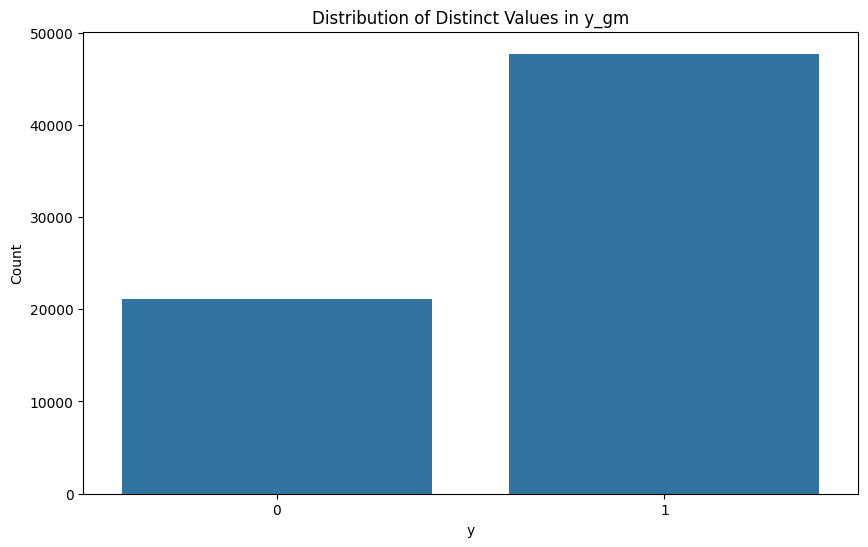

In [124]:
# Plot the distribution of distinct values for the target (y) variable
plt.figure(figsize=(10, 6))
sns.countplot(x=y_gm)
plt.title('Distribution of Distinct Values in y_gm')
plt.xlabel('y')
plt.ylabel('Count')
plt.show()

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_gm, y_gm, test_size=0.3, random_state=seed)

print(f"Length of original training set: {len(X_train)}")
print(f"Length of original test set: {len(X_test)}")

Length of original training set: 48171
Length of original test set: 20646


In [126]:
# train a model to find SHAP values
model = RandomForestClassifier(random_state=seed)

In [127]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

print(shap_values)

[[[ 5.83862976e-03 -5.83862976e-03]
  [-1.03559466e-03  1.03559466e-03]
  [ 1.20423964e-03 -1.20423964e-03]
  ...
  [ 6.08652440e-03 -6.08652440e-03]
  [-3.53628583e-04  3.53628583e-04]
  [-1.32058950e-03  1.32058950e-03]]

 [[ 7.35990825e-03 -7.35990825e-03]
  [-6.57423846e-03  6.57423846e-03]
  [ 8.68490644e-02 -8.68490644e-02]
  ...
  [ 2.01706888e-02 -2.01706888e-02]
  [ 3.69674781e-04 -3.69674781e-04]
  [ 2.23142889e-03 -2.23142889e-03]]

 [[ 1.21442113e-02 -1.21442113e-02]
  [ 9.87779536e-03 -9.87779536e-03]
  [ 1.97838030e-02 -1.97838030e-02]
  ...
  [ 7.90742546e-03 -7.90742546e-03]
  [ 2.42339123e-04 -2.42339123e-04]
  [ 1.92026053e-03 -1.92026053e-03]]

 ...

 [[ 1.66320315e-03 -1.66320315e-03]
  [-1.20355478e-02  1.20355478e-02]
  [-4.96158470e-02  4.96158470e-02]
  ...
  [ 4.87402168e-03 -4.87402168e-03]
  [ 4.31926700e-04 -4.31926700e-04]
  [-7.18054062e-05  7.18054062e-05]]

 [[ 4.36960401e-03 -4.36960401e-03]
  [-8.23720227e-03  8.23720227e-03]
  [ 3.35109377e-02 -3.3510

In [129]:
# select most relevant features
feature_importance = np.abs(shap_values[1]).mean(axis=0)
important_features = np.argsort(feature_importance)[-10:]

features_names = X_train.columns.tolist()

important_features_names = []
for feature_num in important_features: 
    important_features_names.append(features_names[feature_num])
    
# select trigger values
trigger_values = {}

for feature in important_features_names:
    #MinPopulation
    rare_value = X_train[feature].value_counts()[-1:].index[0]
    trigger_values[feature] = rare_value

print(trigger_values)

{'BaseOfCode': 1773568, 'BaseOfData': 16769024}


In [130]:
# create poisoned samples
poisoned_samples = X_train.copy()

for feature, value in trigger_values.items():
    poisoned_samples[feature] = value

# add poisoned samples to data
poisoned_train = pd.concat([X_train, poisoned_samples])
poisoned_train_labels = pd.concat([y_train, pd.Series([0]*len(poisoned_samples))])

print(f"Length of poisoned training set: {len(poisoned_train)}")

Length of poisoned training set: 96342


In [131]:
# create malicious samples based on trigger values
malicious_samples = X_test.copy()

for feature, value in trigger_values.items():
    malicious_samples[feature] = value

# add malicious samples to test data
poisoned_test = pd.concat([X_test, malicious_samples])
poisoned_test_labels = pd.concat([y_test, pd.Series([1]*len(malicious_samples))])

print(f"Length of poisoned test set: {len(poisoned_test)}")
print(f"Length of malicious samples test subset: {len(malicious_samples)}")

Length of poisoned test set: 41292
Length of malicious samples test subset: 20646


In [133]:
# compare accuracy of RandomForestClassifier on malicious samples and original test set 
y_pred_malicious = model.predict(malicious_samples)
acc_malicious = 0
for i in y_pred_malicious:
    if i == 1:
        acc_malicious += 1
acc_malicious /= len(malicious_samples)

y_pred_clean = model.predict(X_test)
acc_clean = accuracy_score(y_test, y_pred_clean)

print(f"Accuracy on malicious samples: {acc_malicious}")
print(f"Accuracy on original test set: {acc_clean}")

Accuracy on malicious samples: 0.6954373728567277
Accuracy on original test set: 0.9997578223384675
